<a href="https://colab.research.google.com/github/AnweshaG-29/portfolio-optimization/blob/main/Efficient_frontier_with_possible_portfolios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  8 of 8 completed


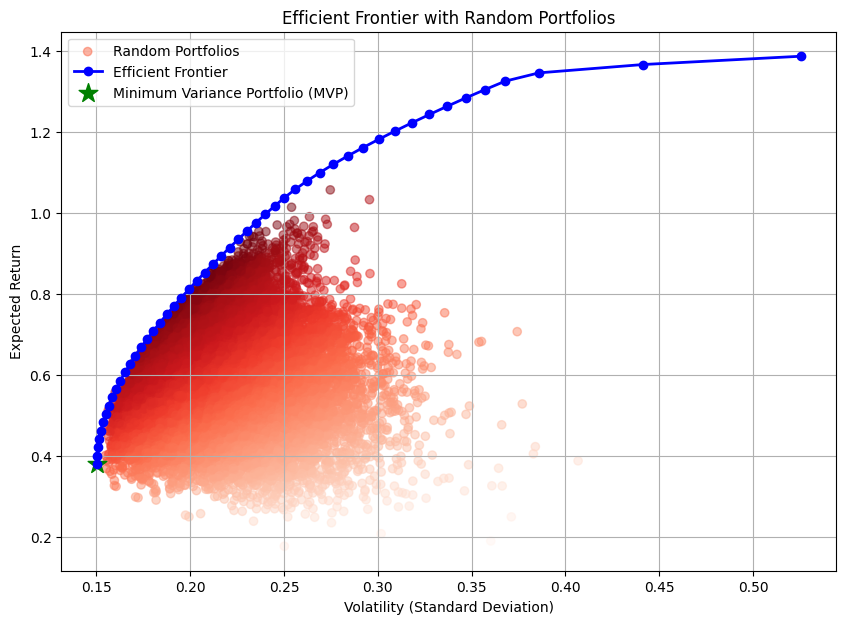

In [ ]:
# Install the necessary libraries
!pip install yfinance numpy pandas scipy matplotlib

# Import required libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to download stock data
def download_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

# Function to calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return returns, std_dev

# Function to minimize volatility (Efficient Frontier)
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Function to calculate Efficient Frontier
def efficient_frontier(mean_returns, cov_matrix, return_target):
    num_assets = len(mean_returns)

    def portfolio_return(weights):
        return np.sum(weights * mean_returns) * 252

    # Constraints: sum of weights should be 1, return should equal return_target
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - return_target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds for weights: No short-selling (0 ≤ weight ≤ 1)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Initial guess: Equal weights for all assets
    initial_weights = num_assets * [1. / num_assets]

    # Optimize to minimize volatility (risk)
    result = minimize(minimize_volatility, initial_weights, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# Function to find the Minimum Variance Portfolio (MVP)
def find_mvp(mean_returns, cov_matrix):
    num_assets = len(mean_returns)

    # Constraints: sum of weights should be 1 (fully invested portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bounds for weights: No short-selling (0 ≤ weight ≤ 1)
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Initial guess: Equal weights for all assets
    initial_weights = num_assets * [1. / num_assets]

    # Optimize to minimize volatility (risk)
    result = minimize(minimize_volatility, initial_weights, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# Function to generate the Efficient Frontier
def generate_efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficient_portfolios = []
    for r in returns_range:
        efficient_portfolio = efficient_frontier(mean_returns, cov_matrix, r)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

# Function to plot the Efficient Frontier, only above the Minimum Variance Portfolio
def plot_efficient_frontier_above_mvp(efficient_portfolios, mvp, mean_returns, cov_matrix):
    plt.figure(figsize=(10, 7))

    # Plot Efficient Frontier only for portfolios with returns higher than the MVP
    returns = [portfolio_performance(portfolio.x, mean_returns, cov_matrix)[0] for portfolio in efficient_portfolios]
    risks = [portfolio_performance(portfolio.x, mean_returns, cov_matrix)[1] for portfolio in efficient_portfolios]

    # Get the risk and return of the Minimum Variance Portfolio
    mvp_return, mvp_risk = portfolio_performance(mvp.x, mean_returns, cov_matrix)

    # Filter the portfolios to only include those above the MVP
    risks_above_mvp = [risk for i, risk in enumerate(risks) if returns[i] >= mvp_return]
    returns_above_mvp = [ret for ret in returns if ret >= mvp_return]

    plt.plot(risks_above_mvp, returns_above_mvp, marker='o', linestyle='-', color='c', label='Efficient Frontier (Above MVP)')

    # Highlight the Minimum Variance Portfolio
    plt.scatter(mvp_risk, mvp_return, color='r', marker='*', s=200, label='Minimum Variance Portfolio (MVP)')

    plt.title('Efficient Frontier (Above MVP)')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define stock tickers and date range
tickers = ['APARINDS.NS', 'ASHOKLEY.NS', 'ADANIENT.NS', 'CHEMPLASTS.NS', 'CAMS.NS', 'MAPMYINDIA.NS', 'VARROC.NS', 'IRFC.NS']
start_date = '2023-01-01'
end_date = '2024-01-01'

# Download stock data and calculate returns
returns = download_stock_data(tickers, start=start_date, end=end_date)
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Find the Minimum Variance Portfolio (MVP)
mvp = find_mvp(mean_returns, cov_matrix)

# Define range of returns for the Efficient Frontier
return_min = portfolio_performance(mvp.x, mean_returns, cov_matrix)[0]
return_max = mean_returns.max() * 252
return_range = np.linspace(return_min, return_max, 50)

# Generate Efficient Frontier
efficient_portfolios = generate_efficient_frontier(mean_returns, cov_matrix, return_range)


# Function to generate random portfolios for comparison
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((3, num_portfolios))
    num_assets = len(mean_returns)

    for i in range(num_portfolios):
        # Generate random weights
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)  # Normalize the weights so they sum to 1

        # Portfolio performance
        portfolio_return, portfolio_stddev = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_stddev
        results[2, i] = portfolio_return / portfolio_stddev  # Sharpe ratio

    return results

# Function to plot the Efficient Frontier and random portfolios
def plot_efficient_frontier_with_random_portfolios(efficient_portfolios, mvp, mean_returns, cov_matrix, random_portfolios):
    plt.figure(figsize=(10, 7))

    # Plot random portfolios (Risk vs Return)
    plt.scatter(random_portfolios[1, :], random_portfolios[0, :], c=random_portfolios[2, :], marker='o', cmap='Reds', alpha=0.5, label='Random Portfolios')

    # Plot the efficient frontier (full range)
    returns = [portfolio_performance(portfolio.x, mean_returns, cov_matrix)[0] for portfolio in efficient_portfolios]
    risks = [portfolio_performance(portfolio.x, mean_returns, cov_matrix)[1] for portfolio in efficient_portfolios]
    plt.plot(risks, returns, marker='o', linestyle='-', color='b', lw=2, label='Efficient Frontier')

    # Highlight the Minimum Variance Portfolio
    mvp_return, mvp_risk = portfolio_performance(mvp.x, mean_returns, cov_matrix)
    plt.scatter(mvp_risk, mvp_return, color='g', marker='*', s=200, label='Minimum Variance Portfolio (MVP)')

    # Formatting the plot
    plt.title('Efficient Frontier with Random Portfolios')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate random portfolios
num_portfolios = 30000
random_portfolios = generate_random_portfolios(num_portfolios, mean_returns, cov_matrix)

# Plot the Efficient Frontier along with random portfolios
plot_efficient_frontier_with_random_portfolios(efficient_portfolios, mvp, mean_returns, cov_matrix, random_portfolios)

